# Pre-processing sandbox

## == Initialize Environment == 

In [23]:
# Library imports
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt    

from nltk import PorterStemmer, WordNetLemmatizer
import codecs

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from tqdm import tqdm
import torch.nn as nn

import re
from functools import partial

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

# Pre-trained models
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel
from transformers.models.bert.modeling_bert import BertOnlyMLMHead
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler


def fix_seed(seed=420.69):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
#   np.random.seed(seed)
#   random.seed(seed)

fix_seed()

data_path = '../bin/data'
embeddings_path = '../bin/word_embeddings'
model_save_path = '../bin/models'

from util.datafunctions import *
from util.evaluation import *

if not torch.cuda.is_available():
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda'

DEVICE

'cuda'

## === Utils ===

### Data related util functions

In [24]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def generate_data_splits(train_data):
    # The stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. 

    X_train, X_val, y_train, y_val = train_test_split(train_data[['text', 'keyword', 'country_code']]
                                                    , train_data['labels']
                                                    , train_size=0.8
                                                    , test_size=0.2
                                                    , random_state=0
                                                    , stratify=train_data[['labels']]
                                                    )
   
    return X_train, X_val, y_train, y_val


def pie_data_distributions(pie_series, pie_series_label):
    """Plots some pie charts for data distribution (Assume len(pie_series) inputs)

    Args:
        pie_series (_type_): pandas series 
        pie_series_label (_type_): for the title
    """

    assert len(pie_series) == len(pie_series_label) and "expected inputs of same length"

    _, axs = plt.subplots(1, len(pie_series), figsize=(len(pie_series)*5, 5))

    for idx, (series, title) in enumerate(zip(pie_series, pie_series_label)):
        tmp = series.value_counts()

        wedges, _, _ = axs[idx].pie(tmp, labels=tmp.index, autopct='%1.1f%%', startangle=90)
        legend_labels = [f'{label} ({count})' for label, count in zip(tmp.index, tmp)]
        axs[idx].legend(wedges, legend_labels, title="Class 1 and 0", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        axs[idx].set_title(f'Distribution for {title}')

    plt.tight_layout()
    plt.show()

In [25]:
def plot_data_splits(X_train, X_val, y_train, y_val, test_data):
    print("=== DISTRIBUTION FOR TRAINING DATA ===")
    pie_data_distributions(
        [X_train['country_code'], X_train['keyword'], y_train],
        ['train country_code label', 'train keyword label', 'train binary classification']
    )

    print("=== DISTRIBUTION FOR VALIDATION DATA ===")
    pie_data_distributions(
        [X_val['country_code'], X_val['keyword'], y_val],
        ['validation country_code label', 'validation keyword label', 'validation binary classification']
    )

    print("=== DISTRIBUTION FOR TEST DATA ===")
    pie_data_distributions(
        [test_data['country_code'], test_data['keyword']],
        ['test country_code label', 'test keyword label']
    )

## === Loading the Data ===

In [26]:
# Import Data
train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'
test_data_path  = f'{data_path}/task4_test.tsv'

train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])
test_data  = pd.read_csv(test_data_path,  delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text'])

train_data = train_data.drop(['art_id'], axis=1)
test_data = test_data.drop(['art_id'], axis=1)

In [27]:
# Concatenate label information to train data
dev_label_path   = f'{data_path}/dev_semeval_parids-labels.csv'
train_label_path = f'{data_path}/train_semeval_parids-labels.csv'

dev_label   = pd.read_csv(dev_label_path, delimiter=',')
train_label = pd.read_csv(train_label_path, delimiter=',')

detailed_labels = pd.concat([dev_label, train_label], ignore_index=True, join='inner', names=['simple', 'detailed'])
train_data = pd.merge(train_data, detailed_labels, on='par_id')
train_data = train_data.rename(columns={'label_x': 'binary_label', 'label_y': 'label_detailed'})

In [28]:
# Add Binary Classification column for ease of checking
train_data.loc[:, 'labels'] = 0
train_data.loc[train_data['binary_label'].isin([2,3,4]), 'labels'] = 1

In [29]:
train_data = train_data.dropna(subset = 'text')
test_data = test_data.dropna(subset = 'text')

test_data['labels'] = -1 # for compatibility with the dataloader, set a dummy label variable

In [30]:
id2label = {0: "non-PCL", 1: "PCL"}
label2id = {"non-PCL": 0, "PCL": 1}

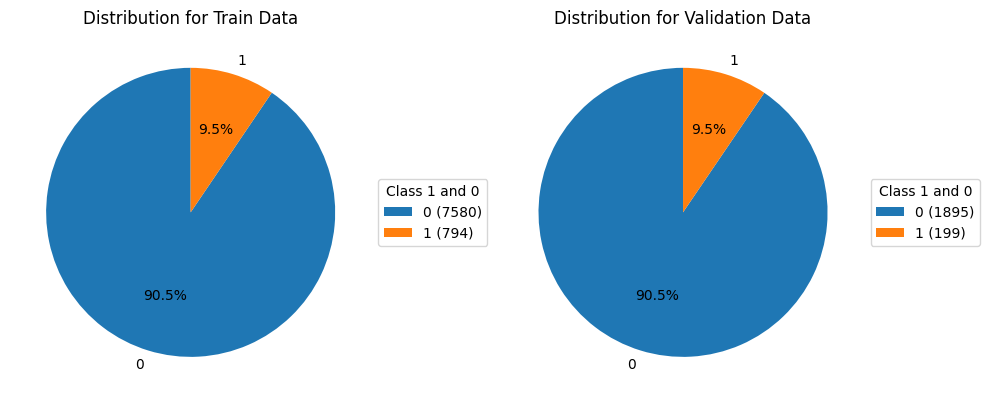

In [31]:
X_train, X_val, y_train, y_val = generate_data_splits(train_data)

pie_data_distributions([y_train, y_val], ['Train Data', 'Validation Data'])

## === Data Sampling ===

In [32]:


def find_cosine_similarity_between_two_sentences(sentence1, sentence2):
    """Find the cosine similarity between two sentences using word embeddings

    Args:
        sentence1 (str): first sentence
        sentence2 (str): second sentence

    Returns:
        float: cosine similarity between the two sentences
    """    
    # Tokenize the sentences
    sentence1 = sentence1.split()
    sentence2 = sentence2.split()
    
    # Get the word vectors
    word_vectors = [word_embeddings.get(word, np.zeros(300)) for word in sentence1]
    word_vectors2 = [word_embeddings.get(word, np.zeros(300)) for word in sentence2]
    
    # Average the word vectors
    sentence_vector = np.mean(word_vectors, axis=0)
    sentence_vector2 = np.mean(word_vectors2, axis=0)
    
    # Find the cosine similarity
    cosine_similarity = dot(sentence_vector, sentence_vector2)/(norm(sentence_vector)*norm(sentence_vector2))
    
    return cosine_similarity

### 0. Stop Word Removal

explanation: https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

we don't always remove stop words, e.g. https://www.ibm.com/docs/en/watson-explorer/11.0.0?topic=analytics-stop-word-removal when a sentence consists only of stop words, but this library takes care of it"Surprisingly, the stopwords received as much attention as non-stop words, but removing them has no effect in MRR performances." https://stackoverflow.com/questions/63633534/is-it-necessary-to-do-stopwords-removal-stemming-lemmatization-for-text-classif 

In [33]:
from gensim.parsing.preprocessing import remove_stopwords

# Another sample text
new_text = "I do not like you because I'm better than you"
 
# Remove stopwords using Gensim
new_filtered_text = remove_stopwords(new_text)

print("Original Text:", new_text)
print("Text after Stopword Removal:", new_filtered_text)

Original Text: I do not like you because I'm better than you
Text after Stopword Removal: I like I'm better


### 1. "Easy Data Augmentation Techniques"

(Initially) Inspired by https://datascience.stackexchange.com/questions/27671/how-do-you-apply-smote-on-text-classification 

Code implemented from https://arxiv.org/pdf/1901.11196.pdf

In [34]:
!git clone https://github.com/jasonwei20/eda_nlp.git
from eda_nlp.code.eda import *

fatal: destination path 'eda_nlp' already exists and is not an empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [35]:
# Default parameters have shown good performance in the original paper
source_sentence = "I hate you because I think that I'm better than you"
result = eda(source_sentence, alpha_ri=0.0, num_aug=5)
result

['i hate because think that im better than you',
 'i hate you because i that think im better than you',
 'i hate you because i mean that im better than you',
 'hate you because i think that im better you',
 'i hate you because i im that think better than you',
 'i hate you because i think that im better than you']

In [36]:
# find_cosine_similarity_between_two_sentences(source_sentence, result[0])

In [37]:
def generate_eda(data, num_aug=3, probability=0.1):
    eda_upsampled = data[data['labels'] == 1]
    eda_upsampled.loc[:, 'text'] = eda_upsampled.apply(
        lambda row: eda(row['text']
                        , num_aug=num_aug
                        , alpha_ri=probability
                        , alpha_rs=probability
                        , p_rd    =probability
                        , alpha_sr=probability
                        ), axis=1) #alpha_ri=0.0, num_aug=num_aug), axis=1)

    upsampled_positives = pd.DataFrame(columns=data.columns)

    for _, row in eda_upsampled.iterrows():
        for upsample in row['text']:
            # insert into upsampled_positives the row['text'] and the remaining columns in variable row
            new_row = pd.DataFrame([row], columns=data.columns)
            new_row['text'] = upsample
            upsampled_positives = pd.concat([upsampled_positives, new_row], ignore_index=True)

    train_data_minority_upsampled = pd.concat([upsampled_positives, data[data['labels'] == 0]], ignore_index=True)

    return train_data_minority_upsampled

In [38]:
# train_data_minority_upsampled = generate_eda(train_data, num_aug=10)

# X_train, X_val, y_train, y_val = generate_data_splits(train_data_minority_upsampled)
# pie_data_distributions([y_train, y_val], ['Train Data', 'Validation Data'])

### 2. Rephrasing

https://github.com/Vamsi995/Paraphrase-Generator

https://huggingface.co/Vamsi/T5_Paraphrase_Paws

Paraphrasing only really works on longer sentences

In [39]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def paraphrase_text(text: str, num_return_sequences: int):
    """Paraphrase the input text using the T5 model

    Args:
        text (str): input text
        num_return_sequences (int): number of paraphrases to return

    Returns:
        list: list of paraphrased text
    """    

    # Format text for the model to understand the paraphrasing task
    text =  "paraphrase: " + text + " </s>"

    # Load model
    tokenizer = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")  
    model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws").to('cuda')

    encoding = tokenizer.encode_plus(text, padding='longest', return_tensors="pt")
    input_ids, attention_masks = encoding["input_ids"].to("cuda"), encoding["attention_mask"].to("cuda")

    # Generate paraphrases
    outputs = model.generate(
        input_ids=input_ids, attention_mask=attention_masks,
        max_length=256,
        do_sample=True,
        top_k=120,
        top_p=0.95,
        early_stopping=True,
        num_return_sequences=num_return_sequences
    )

    # Decode the generated paraphrases
    return [tokenizer.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True) for output in outputs]

for text in ["I don't like you because I'm better than you",
             "We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism ."]:
    for paraphrase in paraphrase_text(text, 5):
        print(paraphrase)

/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


I don't like you because I am better than you
I don't like you because I'm better than you
I don't like you because I am better than you
I don't like you because I'm better than you
I don't like you because I am better than you.
We're living in times of absolute insanity, as I'm pretty sure most people are aware. waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they are trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb instructions burnt long ago in a fire, and the likelihood of imminent catastrophe seems the worst, so it is natural for people to become inured
We are living in times of absolute insanity, as I'm pretty sure most people are aware of : for a while, waking up every day to check the news appeared to carry the same feeling of panic and dread that action heroes will probably face when they try to decide whether to cut the blue or green wire on a tic

### 3. Contextual Word Embeddings for Sentence Augmenter

https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb

seems to be bad for long sentences, good for short!

In [40]:
# !pip install nlpaug

import nlpaug.augmenter.sentence as nas

aug = nas.ContextualWordEmbsForSentenceAug(model_path='distilgpt2')

for text in ["I don't like you because I'm better than you",
             "More than 750 trolleys of food donated to those in need",
             "The quick brown fox jumps over the lazy dog",
             "We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism ."]:
    print(aug.augment(text))


["I don't like you because I'm better than you A This , D H S I 2 We I S A � You R A This G , The The ."]
['More than 750 trolleys of food donated to those in need In the The The The I B H .']
['The quick brown fox jumps over the lazy dog This T G It You The The C In A The A The H I We 1 W This This The I D the R This .']
["We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism . � If I The A and D and This M This The I , D A This .

### 4. AugGPT

https://github.com/yhydhx/AugGPT

### 5. Translate and back

https://github.com/NandhiniN85/Class-Imbalancing/blob/main/NLP%20-%20Class%20Imbalanced.ipynb

https://www.analyticsvidhya.com/blog/2020/11/handling-imbalanced-data-machine-learning-computer-vision-and-nlp/

In [52]:
# !pip install googletrans

# from googletrans import Translator # google translator doesn't seem to be working: issue: https://stackoverflow.com/questions/52455774/googletrans-stopped-working-with-error-nonetype-object-has-no-attribute-group/52456197#52456197

# translator = Translator()

# def Portugese_translation(x):
#     print(x)    
#     german_translation = translator.translate(x, dest='pt')    
#     return german_translation.text

# def English_translation(x):
#     print(x)    
#     english_translation = translator.translate(x, dest='en')    
#     return english_translation.text

# x = Portugese_translation("warning for using windows disk space")
# English_translation(x)

# !pip install -U deep-translator
from deep_translator import GoogleTranslator

# get random subset of languages from supported languages

GoogleTranslator().get_supported_languages()

def multi_translate(text, depth=3):
    random_languages = np.random.choice(list(GoogleTranslator().get_supported_languages()), depth-1, replace=False)

    curr_language = 'english'

    for language in random_languages:
        text = GoogleTranslator(source=curr_language, target=language).translate(text)
        curr_language = language

    return GoogleTranslator(source=curr_language, target='english').translate(text)

# multi_translate("More than 750 trolleys of food donated to those in need")

for text in ["I don't like you because I'm better than you",
             "More than 750 trolleys of food donated to those in need",
             "The quick brown fox jumps over the lazy dog",
             "We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism ."]:
    
    print(multi_translate(text))

I don't like you because I'm better than you
More than 750 food trolleys were donated to those in need
A fast brown fox jumps over a lazy dog
We live in a time of complete despair that I am sure most people know. For a while, the anxiety of checking the news every day seemed to be the anxiety and fear that the action hero might experience trying to cut the blue or white line on the bomb being ticked. Unless instructed to do so by firebombs long ago, the imminent catastrophe The result is most likely. But at the same time, it is very difficult to stay on that edge, so it is common for people who are obsessed with constant chaos to fall into the misery of despair and pessimism.


In [48]:
augmented_sentence = paraphrase_text('More than 750 trolleys of food donated to those in need', 5)
for sentence in augmented_sentence:
    print('---')
    print(sentence)
    print(multi_translate(sentence))

/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


---
More than 750 trolleys of food donated to those in need
More than 750 food carts donated to those most in need
---
Over 750 trolleys of food are donated to those in need.
More than 750 carts of food were donated to those in need.
---
More than 750 trolleys of food were donated to those in need.
More than 750 carts of food were donated to those in need.
---
More than 750 trolleys of food donated to those in need
More than 750 food carts donated to those most in need
---
More than 750 trolleys of food donated to those in need.
More than 750 carts of food were donated to those in need.


### 6. Sentence reordering

In [53]:
def random_sentence_reordering(text):
    """Randomly reorder the words in the input text

    Args:
        text (str): input text

    Returns:
        str: reordered text
    """    
    text = text.split('.')
    np.random.shuffle(text)
    return '.'.join(text)

In [55]:
random_sentence_reordering("Sentence 1 is in the first position. It may contain some important information for sentence 2, but yet, it may not. This is the beauty of data pre-processing. Sometimes, it doesn't make sense, but it doesn't always have to.")

" It may contain some important information for sentence 2, but yet, it may not.Sentence 1 is in the first position. Sometimes, it doesn't make sense, but it doesn't always have to.. This is the beauty of data pre-processing"